In [7]:

from __future__ import print_function
import numpy as np
from keras.layers import Input, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, LSTM, Reshape, Lambda
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential
from keras import backend as K
from keras.layers  import TimeDistributed, TimeDistributedDense
import os, sys, re
from nltk import tokenize
import nltk
nltk.download('punkt')
import string 
import pandas as pd
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sivagurukannan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
import sys
print(sys.version)

2.7.12 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
TEXT_DATA_DIR = './speech_data/data/'

In [13]:
# Load the labels 
df = pd.read_csv('./speech_data/presidents_meta.csv')
label_dict = dict(zip(list(df.foldername), list(df.label)))

In [14]:
texts = []  # list of text samples
# labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids


for name in sorted(os.listdir(TEXT_DATA_DIR)):

    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        for fname in sorted(os.listdir(path)):
            if 'combined' not in fname and 'combines' not in fname:
                president_name = path.split('/')[-1]
                fpath = os.path.join(path, fname)
                f = open(fpath)
                if (president_name in label_dict):
                    labels.append(label_dict[president_name])
                    line = f.read()
                    line = re.sub(r'[^\x00-\x7F]+',' ', line).lower()
                    texts.append(line)
                f.close()
                

print('Found %s texts.' % len(texts))
print('Found %s texts.' % len(labels))

Found 862 texts.
Found 862 texts.


In [15]:
texts[500][:1000]

'the president. good afternoon, ladies and gentlemen.i have been asked to give a statement about the consular convention that is pending before the united states senate.i should like to say very briefly that i hope the senate will give its advice and consent to the proposed convention with the u.s.s.r. i feel very strongly that the ratification of this treaty is very much in our national interest. i feel this way for two principal reasons:first, we need this treaty to protect 18,000 american citizens who each year travel from this country to the soviet the convention requires immediate notification to us whenever an american is arrested in the soviet union. it insures our right to visit that citizen within 4 and as often thereafter as is desirable.we think that we need these rights help to protect american citizens. these are rights which the soviet citizens already have who travel in this country, because guaranteed by our constitution.second, the convention does not require the openi

In [16]:
MAX_NB_WORDS = 100
print(len(texts))
mini_test = texts[:10]
print(list(map(len, mini_test)))
MAX_SEQUENCE_LENGTH = 100
MAX_SENTENCES = 100

862
[2665, 11080, 10013, 1927, 81929, 62451, 51770, 54751, 5014, 6845]


In [17]:
def pad_dense_list(speech, maxsentence):
    
    each_sub_len = len(speech[0])
    Z = np.zeros((maxsentence, each_sub_len))
    #print("Shape of Z{}, list {}", Z.shape, len(speech))
    for index, row in enumerate(speech):
        if (index >= maxsentence):
            break
        
        Z[index] = row
    #print(Z) 
    return Z

In [18]:
def preprocess_text(mini_test):
    #mini_test = "mini test. hello world."
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(mini_test)
    text_encoded = np.zeros((len(texts),MAX_SENTENCES,MAX_SEQUENCE_LENGTH))
    #print(text_encoded.shape)
    word_index = tokenizer.word_index
    for enu, speech in enumerate(mini_test):
        sents = tokenize.sent_tokenize(speech)
        if(len(sents) == 0):
            continue
        sequences = tokenizer.texts_to_sequences(sents)
        
        #print(len(sequences))
        #print('Found %s unique tokens.' % len(word_index))
        data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
        text_encoded[enu] = (pad_dense_list(data, 100))
    return word_index, text_encoded
word_index, text_encoded = preprocess_text(texts)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  26.  22.  19.
   4.  32.   1.  21.  25.  13.   4.   1.   2.   1.  72.  73.  73.   1.   4.
   2.  73.   4.   1.   2.  73.  23.   1.   2.  13.]


In [19]:
# First Speech encoding
data = text_encoded
labels = np.asarray(labels)
print(data.shape)
print(labels.shape)

(862, 100, 100)
(862,)


In [20]:
new_data = data
data = data.reshape(data.shape[0], data.shape[1]*data.shape[1])

In [21]:
data.shape

(862, 10000)

In [22]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
# labels = labels[indices]
VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of data tensor: (862, 10000)
Shape of label tensor: (862,)


In [23]:
embeddings_index = {}
GLOVE_DIR = '../glove.6B/'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [24]:
EMBEDDING_DIM = 100

In [25]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [26]:
data.shape

(862, 10000)

In [27]:
VOCAB_SIZE = len(word_index) + 1
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100
MAX_SENTENCES = 100
EMBEDDING_INPUT_LENGTH = MAX_SEQUENCE_LENGTH*MAX_SENTENCES
WORD_LSTM_DIM = 100
SENT_LSTM_DIM = 100
NUM_CLASSES = 8

In [62]:
print(y_train)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

### Hierarchical-Average model

In [28]:
model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE, 
                            EMBEDDING_DIM, 
                            weights = [embedding_matrix],
                            input_length=EMBEDDING_INPUT_LENGTH,
                            trainable=False)
model.add(embedding_layer)
model.add(Reshape((MAX_SENTENCES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM,), input_shape=(EMBEDDING_INPUT_LENGTH,EMBEDDING_DIM,)))
# model.add(TimeDistributed(LSTM(WORD_LSTM_DIM, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), return_sequences=True)))
model.add(Lambda(lambda x: K.mean(x, axis=2, keepdims=True), output_shape=lambda s: (s[0], 1, s[1],s[3])))
model.add(TimeDistributed(LSTM(SENT_LSTM_DIM, input_shape=(MAX_SENTENCES, EMBEDDING_DIM), return_sequences=True)))
model.add(Reshape((MAX_SENTENCES,SENT_LSTM_DIM), input_shape=(1,MAX_SENTENCES,SENT_LSTM_DIM)))
model.add(Lambda(lambda x: K.mean(x, axis=1, keepdims=True), output_shape=lambda s: (s[0], s[2])))
model.add(Reshape((SENT_LSTM_DIM,)))
model.add(Dense(NUM_CLASSES, input_dim=SENT_LSTM_DIM, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 10000, 100)    3736500     embedding_input_1[0][0]          
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 100, 100, 100) 0           embedding_1[0][0]                
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 1, 100, 100)   0           reshape_1[0][0]                  
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (None, 1, 100, 100)   80400       lambda_1[0][0]                   
___________________________________________________________________________________________

In [83]:
x_train.shape

(690, 10000)

In [64]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),nb_epoch=5, batch_size=10)

Train on 690 samples, validate on 172 samples
Epoch 1/5
690/690 [==============================] - 33s - loss: 1.8519 - acc: 0.2435 - val_loss: 2.3439 - val_acc: 0.0058
Epoch 2/5
690/690 [==============================] - 29s - loss: 1.8223 - acc: 0.2319 - val_loss: 2.2654 - val_acc: 0.0058
Epoch 3/5
690/690 [==============================] - 30s - loss: 1.8109 - acc: 0.2536 - val_loss: 2.3372 - val_acc: 0.0116
Epoch 4/5
690/690 [==============================] - 29s - loss: 1.8114 - acc: 0.2304 - val_loss: 2.3237 - val_acc: 0.0116
Epoch 5/5
690/690 [==============================] - 30s - loss: 1.8092 - acc: 0.2246 - val_loss: 2.3425 - val_acc: 0.0116


# Hierarchical-Sum model


In [119]:
model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE, 
                            EMBEDDING_DIM, 
                            #weights = [embedding_matrix],
                            input_length=EMBEDDING_INPUT_LENGTH,
                            trainable=False)
model.add(embedding_layer)
model.add(Reshape((MAX_SENTENCES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM,), input_shape=(EMBEDDING_INPUT_LENGTH,EMBEDDING_DIM,)))
model.add(TimeDistributed(LSTM(WORD_LSTM_DIM, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), return_sequences=True)))
model.add(Lambda(lambda x: K.sum(x, axis=2, keepdims=True), output_shape=lambda s: (s[0], 1, s[1],s[3])))
model.add(TimeDistributed(LSTM(SENT_LSTM_DIM, input_shape=(MAX_SENTENCES, EMBEDDING_DIM), return_sequences=True)))
model.add(Reshape((MAX_SENTENCES,SENT_LSTM_DIM), input_shape=(1,MAX_SENTENCES,SENT_LSTM_DIM)))
model.add(Lambda(lambda x: K.sum(x, axis=1, keepdims=True), output_shape=lambda s: (s[0], s[2])))
model.add(Reshape((SENT_LSTM_DIM,)))
model.add(Dense(NUM_CLASSES, input_dim=SENT_LSTM_DIM, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
print(model.summary())

ValueError: Layer weight shape (37365, 30) not compatible with provided weight shape (37365, 100)

In [25]:
# 

def Word_Sequential():
    model = Sequential()
    model.add(LSTM(100))
    return model


model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE, 
                            EMBEDDING_DIM, 
                            weights = [embedding_matrix],
                            input_length=EMBEDDING_INPUT_LENGTH,
                            trainable=False)
model.add(embedding_layer)
print(model.summary())
model.fit(x_train, y_train, validation_data=(x_val, y_val),nb_epoch=5, batch_size=10)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_4 (Embedding)          (None, 10000, 100)    0           embedding_input_4[0][0]          
Total params: 0
____________________________________________________________________________________________________
None


In [29]:
import seq2seq

In [209]:
VOCAB_SIZE = len(word_index) + 1
EMBEDDING_DIM = 30
MAX_WORD_LENGTH = 5
MAX_SENTENCES = 10
EMBEDDING_INPUT_LENGTH = MAX_WORD_LENGTH*MAX_SENTENCES
WORD_LSTM_DIM = 100
SENT_LSTM_DIM = 100
NUM_CLASSES = 8

In [224]:
from keras.engine.topology import Merge, merge
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

In [216]:
x_train = np.zeros((20, EMBEDDING_INPUT_LENGTH))
y_train = np.zeros((20, 8))

In [225]:
model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE, 
                            EMBEDDING_DIM, 
                            #weights = [embedding_matrix],
                            input_length=EMBEDDING_INPUT_LENGTH,
                            trainable=True)
model.add(embedding_layer)
sequence_input = Input(shape=(EMBEDDING_INPUT_LENGTH, ))
x = embedding_layer(sequence_input)
x = Flatten()(x)
parts = []
for i in range(MAX_SENTENCES):
    y = Lambda(lambda x: x[:, :: MAX_SENTENCES])(x) # Split by Num_sentences. We need an LSTM for each sentence
    z = Reshape((MAX_WORD_LENGTH,EMBEDDING_DIM), input_shape=(MAX_WORD_LENGTH * EMBEDDING_DIM ,))(y)
    l = LSTM(128)(z) # An LSTM for each sentence
    parts.append(l)
# Construct Document vector : 128 X MAX_SENTENCES
merged = merge(parts, mode='concat', concat_axis= 1)
# merged has the document representation  built from sentences 
x = Dense(128, activation='relu')(merged)
preds = Dense(8, activation='softmax')(x)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
print(model.summary())



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_139 (InputLayer)           (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_81 (Embedding)         (None, 50, 30)        1120950     input_139[0][0]                  
____________________________________________________________________________________________________
flatten_69 (Flatten)             (None, 1500)          0           embedding_81[1][0]               
____________________________________________________________________________________________________
lambda_1648 (Lambda)             (None, 150)           0           flatten_69[0][0]                 
___________________________________________________________________________________________

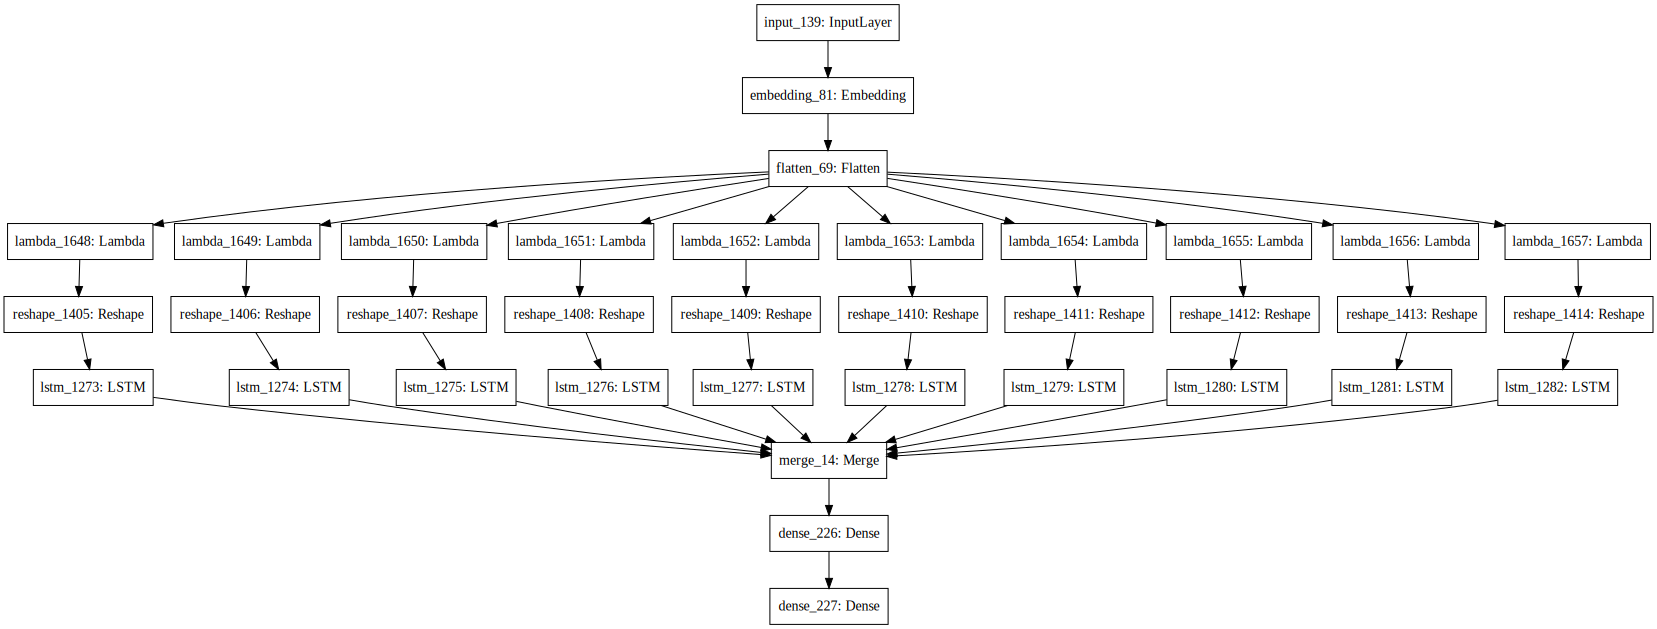

In [226]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
Layer (type)                     Output Shape          Param #     Connected to                     
====================================================================================================
input_133 (InputLayer)           (None, 5000)          0                                            
____________________________________________________________________________________________________
embedding_75 (Embedding)         (None, 5000, 30)      1120950     input_133[0][0]                  
____________________________________________________________________________________________________
flatten_63 (Flatten)             (None, 150000)        0           embedding_75[1][0]               
____________________________________________________________________________________________________
lambda_1498 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1499 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1500 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1501 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1502 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1503 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1504 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1505 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1506 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1507 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1508 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1509 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1510 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1511 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1512 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1513 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1514 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1515 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1516 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1517 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1518 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1519 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1520 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1521 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1522 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1523 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1524 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1525 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1526 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1527 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1528 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1529 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1530 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1531 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1532 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1533 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1534 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1535 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1536 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1537 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1538 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1539 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1540 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1541 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1542 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1543 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1544 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1545 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1546 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1547 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1548 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1549 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1550 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1551 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1552 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1553 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1554 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1555 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1556 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1557 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1558 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1559 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1560 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1561 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1562 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1563 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1564 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1565 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1566 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1567 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1568 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1569 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1570 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1571 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1572 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1573 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1574 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1575 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1576 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1577 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1578 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1579 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1580 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1581 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1582 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1583 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1584 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1585 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1586 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1587 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1588 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1589 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1590 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1591 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1592 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1593 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1594 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1595 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1596 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
lambda_1597 (Lambda)             (None, 1500)          0           flatten_63[0][0]                 
____________________________________________________________________________________________________
reshape_1255 (Reshape)           (None, 50, 30)        0           lambda_1498[0][0]                
____________________________________________________________________________________________________
reshape_1256 (Reshape)           (None, 50, 30)        0           lambda_1499[0][0]                
____________________________________________________________________________________________________
reshape_1257 (Reshape)           (None, 50, 30)        0           lambda_1500[0][0]                
____________________________________________________________________________________________________
reshape_1258 (Reshape)           (None, 50, 30)        0           lambda_1501[0][0]                
____________________________________________________________________________________________________
reshape_1259 (Reshape)           (None, 50, 30)        0           lambda_1502[0][0]                
____________________________________________________________________________________________________
reshape_1260 (Reshape)           (None, 50, 30)        0           lambda_1503[0][0]                
____________________________________________________________________________________________________
reshape_1261 (Reshape)           (None, 50, 30)        0           lambda_1504[0][0]                
____________________________________________________________________________________________________
reshape_1262 (Reshape)           (None, 50, 30)        0           lambda_1505[0][0]                
____________________________________________________________________________________________________
reshape_1263 (Reshape)           (None, 50, 30)        0           lambda_1506[0][0]                
____________________________________________________________________________________________________
reshape_1264 (Reshape)           (None, 50, 30)        0           lambda_1507[0][0]                
____________________________________________________________________________________________________
reshape_1265 (Reshape)           (None, 50, 30)        0           lambda_1508[0][0]                
____________________________________________________________________________________________________
reshape_1266 (Reshape)           (None, 50, 30)        0           lambda_1509[0][0]                
____________________________________________________________________________________________________
reshape_1267 (Reshape)           (None, 50, 30)        0           lambda_1510[0][0]                
____________________________________________________________________________________________________
reshape_1268 (Reshape)           (None, 50, 30)        0           lambda_1511[0][0]                
____________________________________________________________________________________________________
reshape_1269 (Reshape)           (None, 50, 30)        0           lambda_1512[0][0]                
____________________________________________________________________________________________________
reshape_1270 (Reshape)           (None, 50, 30)        0           lambda_1513[0][0]                
____________________________________________________________________________________________________
reshape_1271 (Reshape)           (None, 50, 30)        0           lambda_1514[0][0]                
____________________________________________________________________________________________________
reshape_1272 (Reshape)           (None, 50, 30)        0           lambda_1515[0][0]                
____________________________________________________________________________________________________
reshape_1273 (Reshape)           (None, 50, 30)        0           lambda_1516[0][0]                
____________________________________________________________________________________________________
reshape_1274 (Reshape)           (None, 50, 30)        0           lambda_1517[0][0]                
____________________________________________________________________________________________________
reshape_1275 (Reshape)           (None, 50, 30)        0           lambda_1518[0][0]                
____________________________________________________________________________________________________
reshape_1276 (Reshape)           (None, 50, 30)        0           lambda_1519[0][0]                
____________________________________________________________________________________________________
reshape_1277 (Reshape)           (None, 50, 30)        0           lambda_1520[0][0]                
____________________________________________________________________________________________________
reshape_1278 (Reshape)           (None, 50, 30)        0           lambda_1521[0][0]                
____________________________________________________________________________________________________
reshape_1279 (Reshape)           (None, 50, 30)        0           lambda_1522[0][0]                
____________________________________________________________________________________________________
reshape_1280 (Reshape)           (None, 50, 30)        0           lambda_1523[0][0]                
____________________________________________________________________________________________________
reshape_1281 (Reshape)           (None, 50, 30)        0           lambda_1524[0][0]                
____________________________________________________________________________________________________
reshape_1282 (Reshape)           (None, 50, 30)        0           lambda_1525[0][0]                
____________________________________________________________________________________________________
reshape_1283 (Reshape)           (None, 50, 30)        0           lambda_1526[0][0]                
____________________________________________________________________________________________________
reshape_1284 (Reshape)           (None, 50, 30)        0           lambda_1527[0][0]                
____________________________________________________________________________________________________
reshape_1285 (Reshape)           (None, 50, 30)        0           lambda_1528[0][0]                
____________________________________________________________________________________________________
reshape_1286 (Reshape)           (None, 50, 30)        0           lambda_1529[0][0]                
____________________________________________________________________________________________________
reshape_1287 (Reshape)           (None, 50, 30)        0           lambda_1530[0][0]                
____________________________________________________________________________________________________
reshape_1288 (Reshape)           (None, 50, 30)        0           lambda_1531[0][0]                
____________________________________________________________________________________________________
reshape_1289 (Reshape)           (None, 50, 30)        0           lambda_1532[0][0]                
____________________________________________________________________________________________________
reshape_1290 (Reshape)           (None, 50, 30)        0           lambda_1533[0][0]                
____________________________________________________________________________________________________
reshape_1291 (Reshape)           (None, 50, 30)        0           lambda_1534[0][0]                
____________________________________________________________________________________________________
reshape_1292 (Reshape)           (None, 50, 30)        0           lambda_1535[0][0]                
____________________________________________________________________________________________________
reshape_1293 (Reshape)           (None, 50, 30)        0           lambda_1536[0][0]                
____________________________________________________________________________________________________
reshape_1294 (Reshape)           (None, 50, 30)        0           lambda_1537[0][0]                
____________________________________________________________________________________________________
reshape_1295 (Reshape)           (None, 50, 30)        0           lambda_1538[0][0]                
____________________________________________________________________________________________________
reshape_1296 (Reshape)           (None, 50, 30)        0           lambda_1539[0][0]                
____________________________________________________________________________________________________
reshape_1297 (Reshape)           (None, 50, 30)        0           lambda_1540[0][0]                
____________________________________________________________________________________________________
reshape_1298 (Reshape)           (None, 50, 30)        0           lambda_1541[0][0]                
____________________________________________________________________________________________________
reshape_1299 (Reshape)           (None, 50, 30)        0           lambda_1542[0][0]                
____________________________________________________________________________________________________
reshape_1300 (Reshape)           (None, 50, 30)        0           lambda_1543[0][0]                
____________________________________________________________________________________________________
reshape_1301 (Reshape)           (None, 50, 30)        0           lambda_1544[0][0]                
____________________________________________________________________________________________________
reshape_1302 (Reshape)           (None, 50, 30)        0           lambda_1545[0][0]                
____________________________________________________________________________________________________
reshape_1303 (Reshape)           (None, 50, 30)        0           lambda_1546[0][0]                
____________________________________________________________________________________________________
reshape_1304 (Reshape)           (None, 50, 30)        0           lambda_1547[0][0]                
____________________________________________________________________________________________________
reshape_1305 (Reshape)           (None, 50, 30)        0           lambda_1548[0][0]                
____________________________________________________________________________________________________
reshape_1306 (Reshape)           (None, 50, 30)        0           lambda_1549[0][0]                
____________________________________________________________________________________________________
reshape_1307 (Reshape)           (None, 50, 30)        0           lambda_1550[0][0]                
____________________________________________________________________________________________________
reshape_1308 (Reshape)           (None, 50, 30)        0           lambda_1551[0][0]                
____________________________________________________________________________________________________
reshape_1309 (Reshape)           (None, 50, 30)        0           lambda_1552[0][0]                
____________________________________________________________________________________________________
reshape_1310 (Reshape)           (None, 50, 30)        0           lambda_1553[0][0]                
____________________________________________________________________________________________________
reshape_1311 (Reshape)           (None, 50, 30)        0           lambda_1554[0][0]                
____________________________________________________________________________________________________
reshape_1312 (Reshape)           (None, 50, 30)        0           lambda_1555[0][0]                
____________________________________________________________________________________________________
reshape_1313 (Reshape)           (None, 50, 30)        0           lambda_1556[0][0]                
____________________________________________________________________________________________________
reshape_1314 (Reshape)           (None, 50, 30)        0           lambda_1557[0][0]                
____________________________________________________________________________________________________
reshape_1315 (Reshape)           (None, 50, 30)        0           lambda_1558[0][0]                
____________________________________________________________________________________________________
reshape_1316 (Reshape)           (None, 50, 30)        0           lambda_1559[0][0]                
____________________________________________________________________________________________________
reshape_1317 (Reshape)           (None, 50, 30)        0           lambda_1560[0][0]                
____________________________________________________________________________________________________
reshape_1318 (Reshape)           (None, 50, 30)        0           lambda_1561[0][0]                
____________________________________________________________________________________________________
reshape_1319 (Reshape)           (None, 50, 30)        0           lambda_1562[0][0]                
____________________________________________________________________________________________________
reshape_1320 (Reshape)           (None, 50, 30)        0           lambda_1563[0][0]                
____________________________________________________________________________________________________
reshape_1321 (Reshape)           (None, 50, 30)        0           lambda_1564[0][0]                
____________________________________________________________________________________________________
reshape_1322 (Reshape)           (None, 50, 30)        0           lambda_1565[0][0]                
____________________________________________________________________________________________________
reshape_1323 (Reshape)           (None, 50, 30)        0           lambda_1566[0][0]                
____________________________________________________________________________________________________
reshape_1324 (Reshape)           (None, 50, 30)        0           lambda_1567[0][0]                
____________________________________________________________________________________________________
reshape_1325 (Reshape)           (None, 50, 30)        0           lambda_1568[0][0]                
____________________________________________________________________________________________________
reshape_1326 (Reshape)           (None, 50, 30)        0           lambda_1569[0][0]                
____________________________________________________________________________________________________
reshape_1327 (Reshape)           (None, 50, 30)        0           lambda_1570[0][0]                
____________________________________________________________________________________________________
reshape_1328 (Reshape)           (None, 50, 30)        0           lambda_1571[0][0]                
____________________________________________________________________________________________________
reshape_1329 (Reshape)           (None, 50, 30)        0           lambda_1572[0][0]                
____________________________________________________________________________________________________
reshape_1330 (Reshape)           (None, 50, 30)        0           lambda_1573[0][0]                
____________________________________________________________________________________________________
reshape_1331 (Reshape)           (None, 50, 30)        0           lambda_1574[0][0]                
____________________________________________________________________________________________________
reshape_1332 (Reshape)           (None, 50, 30)        0           lambda_1575[0][0]                
____________________________________________________________________________________________________
reshape_1333 (Reshape)           (None, 50, 30)        0           lambda_1576[0][0]                
____________________________________________________________________________________________________
reshape_1334 (Reshape)           (None, 50, 30)        0           lambda_1577[0][0]                
____________________________________________________________________________________________________
reshape_1335 (Reshape)           (None, 50, 30)        0           lambda_1578[0][0]                
____________________________________________________________________________________________________
reshape_1336 (Reshape)           (None, 50, 30)        0           lambda_1579[0][0]                
____________________________________________________________________________________________________
reshape_1337 (Reshape)           (None, 50, 30)        0           lambda_1580[0][0]                
____________________________________________________________________________________________________
reshape_1338 (Reshape)           (None, 50, 30)        0           lambda_1581[0][0]                
____________________________________________________________________________________________________
reshape_1339 (Reshape)           (None, 50, 30)        0           lambda_1582[0][0]                
____________________________________________________________________________________________________
reshape_1340 (Reshape)           (None, 50, 30)        0           lambda_1583[0][0]                
____________________________________________________________________________________________________
reshape_1341 (Reshape)           (None, 50, 30)        0           lambda_1584[0][0]                
____________________________________________________________________________________________________
reshape_1342 (Reshape)           (None, 50, 30)        0           lambda_1585[0][0]                
____________________________________________________________________________________________________
reshape_1343 (Reshape)           (None, 50, 30)        0           lambda_1586[0][0]                
____________________________________________________________________________________________________
reshape_1344 (Reshape)           (None, 50, 30)        0           lambda_1587[0][0]                
____________________________________________________________________________________________________
reshape_1345 (Reshape)           (None, 50, 30)        0           lambda_1588[0][0]                
____________________________________________________________________________________________________
reshape_1346 (Reshape)           (None, 50, 30)        0           lambda_1589[0][0]                
____________________________________________________________________________________________________
reshape_1347 (Reshape)           (None, 50, 30)        0           lambda_1590[0][0]                
____________________________________________________________________________________________________
reshape_1348 (Reshape)           (None, 50, 30)        0           lambda_1591[0][0]                
____________________________________________________________________________________________________
reshape_1349 (Reshape)           (None, 50, 30)        0           lambda_1592[0][0]                
____________________________________________________________________________________________________
reshape_1350 (Reshape)           (None, 50, 30)        0           lambda_1593[0][0]                
____________________________________________________________________________________________________
reshape_1351 (Reshape)           (None, 50, 30)        0           lambda_1594[0][0]                
____________________________________________________________________________________________________
reshape_1352 (Reshape)           (None, 50, 30)        0           lambda_1595[0][0]                
____________________________________________________________________________________________________
reshape_1353 (Reshape)           (None, 50, 30)        0           lambda_1596[0][0]                
____________________________________________________________________________________________________
reshape_1354 (Reshape)           (None, 50, 30)        0           lambda_1597[0][0]                
____________________________________________________________________________________________________
lstm_1123 (LSTM)                 (None, 128)           81408       reshape_1255[0][0]               
____________________________________________________________________________________________________
lstm_1124 (LSTM)                 (None, 128)           81408       reshape_1256[0][0]               
____________________________________________________________________________________________________
lstm_1125 (LSTM)                 (None, 128)           81408       reshape_1257[0][0]               
____________________________________________________________________________________________________
lstm_1126 (LSTM)                 (None, 128)           81408       reshape_1258[0][0]               
____________________________________________________________________________________________________
lstm_1127 (LSTM)                 (None, 128)           81408       reshape_1259[0][0]               
____________________________________________________________________________________________________
lstm_1128 (LSTM)                 (None, 128)           81408       reshape_1260[0][0]               
____________________________________________________________________________________________________
lstm_1129 (LSTM)                 (None, 128)           81408       reshape_1261[0][0]               
____________________________________________________________________________________________________
lstm_1130 (LSTM)                 (None, 128)           81408       reshape_1262[0][0]               
____________________________________________________________________________________________________
lstm_1131 (LSTM)                 (None, 128)           81408       reshape_1263[0][0]               
____________________________________________________________________________________________________
lstm_1132 (LSTM)                 (None, 128)           81408       reshape_1264[0][0]               
____________________________________________________________________________________________________
lstm_1133 (LSTM)                 (None, 128)           81408       reshape_1265[0][0]               
____________________________________________________________________________________________________
lstm_1134 (LSTM)                 (None, 128)           81408       reshape_1266[0][0]               
____________________________________________________________________________________________________
lstm_1135 (LSTM)                 (None, 128)           81408       reshape_1267[0][0]               
____________________________________________________________________________________________________
lstm_1136 (LSTM)                 (None, 128)           81408       reshape_1268[0][0]               
____________________________________________________________________________________________________
lstm_1137 (LSTM)                 (None, 128)           81408       reshape_1269[0][0]               
____________________________________________________________________________________________________
lstm_1138 (LSTM)                 (None, 128)           81408       reshape_1270[0][0]               
____________________________________________________________________________________________________
lstm_1139 (LSTM)                 (None, 128)           81408       reshape_1271[0][0]               
____________________________________________________________________________________________________
lstm_1140 (LSTM)                 (None, 128)           81408       reshape_1272[0][0]               
____________________________________________________________________________________________________
lstm_1141 (LSTM)                 (None, 128)           81408       reshape_1273[0][0]               
____________________________________________________________________________________________________
lstm_1142 (LSTM)                 (None, 128)           81408       reshape_1274[0][0]               
____________________________________________________________________________________________________
lstm_1143 (LSTM)                 (None, 128)           81408       reshape_1275[0][0]               
____________________________________________________________________________________________________
lstm_1144 (LSTM)                 (None, 128)           81408       reshape_1276[0][0]               
____________________________________________________________________________________________________
lstm_1145 (LSTM)                 (None, 128)           81408       reshape_1277[0][0]               
____________________________________________________________________________________________________
lstm_1146 (LSTM)                 (None, 128)           81408       reshape_1278[0][0]               
____________________________________________________________________________________________________
lstm_1147 (LSTM)                 (None, 128)           81408       reshape_1279[0][0]               
____________________________________________________________________________________________________
lstm_1148 (LSTM)                 (None, 128)           81408       reshape_1280[0][0]               
____________________________________________________________________________________________________
lstm_1149 (LSTM)                 (None, 128)           81408       reshape_1281[0][0]               
____________________________________________________________________________________________________
lstm_1150 (LSTM)                 (None, 128)           81408       reshape_1282[0][0]               
____________________________________________________________________________________________________
lstm_1151 (LSTM)                 (None, 128)           81408       reshape_1283[0][0]               
____________________________________________________________________________________________________
lstm_1152 (LSTM)                 (None, 128)           81408       reshape_1284[0][0]               
____________________________________________________________________________________________________
lstm_1153 (LSTM)                 (None, 128)           81408       reshape_1285[0][0]               
____________________________________________________________________________________________________
lstm_1154 (LSTM)                 (None, 128)           81408       reshape_1286[0][0]               
____________________________________________________________________________________________________
lstm_1155 (LSTM)                 (None, 128)           81408       reshape_1287[0][0]               
____________________________________________________________________________________________________
lstm_1156 (LSTM)                 (None, 128)           81408       reshape_1288[0][0]               
____________________________________________________________________________________________________
lstm_1157 (LSTM)                 (None, 128)           81408       reshape_1289[0][0]               
____________________________________________________________________________________________________
lstm_1158 (LSTM)                 (None, 128)           81408       reshape_1290[0][0]               
____________________________________________________________________________________________________
lstm_1159 (LSTM)                 (None, 128)           81408       reshape_1291[0][0]               
____________________________________________________________________________________________________
lstm_1160 (LSTM)                 (None, 128)           81408       reshape_1292[0][0]               
____________________________________________________________________________________________________
lstm_1161 (LSTM)                 (None, 128)           81408       reshape_1293[0][0]               
____________________________________________________________________________________________________
lstm_1162 (LSTM)                 (None, 128)           81408       reshape_1294[0][0]               
____________________________________________________________________________________________________
lstm_1163 (LSTM)                 (None, 128)           81408       reshape_1295[0][0]               
____________________________________________________________________________________________________
lstm_1164 (LSTM)                 (None, 128)           81408       reshape_1296[0][0]               
____________________________________________________________________________________________________
lstm_1165 (LSTM)                 (None, 128)           81408       reshape_1297[0][0]               
____________________________________________________________________________________________________
lstm_1166 (LSTM)                 (None, 128)           81408       reshape_1298[0][0]               
____________________________________________________________________________________________________
lstm_1167 (LSTM)                 (None, 128)           81408       reshape_1299[0][0]               
____________________________________________________________________________________________________
lstm_1168 (LSTM)                 (None, 128)           81408       reshape_1300[0][0]               
____________________________________________________________________________________________________
lstm_1169 (LSTM)                 (None, 128)           81408       reshape_1301[0][0]               
____________________________________________________________________________________________________
lstm_1170 (LSTM)                 (None, 128)           81408       reshape_1302[0][0]               
____________________________________________________________________________________________________
lstm_1171 (LSTM)                 (None, 128)           81408       reshape_1303[0][0]               
____________________________________________________________________________________________________
lstm_1172 (LSTM)                 (None, 128)           81408       reshape_1304[0][0]               
____________________________________________________________________________________________________
lstm_1173 (LSTM)                 (None, 128)           81408       reshape_1305[0][0]               
____________________________________________________________________________________________________
lstm_1174 (LSTM)                 (None, 128)           81408       reshape_1306[0][0]               
____________________________________________________________________________________________________
lstm_1175 (LSTM)                 (None, 128)           81408       reshape_1307[0][0]               
____________________________________________________________________________________________________
lstm_1176 (LSTM)                 (None, 128)           81408       reshape_1308[0][0]               
____________________________________________________________________________________________________
lstm_1177 (LSTM)                 (None, 128)           81408       reshape_1309[0][0]               
____________________________________________________________________________________________________
lstm_1178 (LSTM)                 (None, 128)           81408       reshape_1310[0][0]               
____________________________________________________________________________________________________
lstm_1179 (LSTM)                 (None, 128)           81408       reshape_1311[0][0]               
____________________________________________________________________________________________________
lstm_1180 (LSTM)                 (None, 128)           81408       reshape_1312[0][0]               
____________________________________________________________________________________________________
lstm_1181 (LSTM)                 (None, 128)           81408       reshape_1313[0][0]               
____________________________________________________________________________________________________
lstm_1182 (LSTM)                 (None, 128)           81408       reshape_1314[0][0]               
____________________________________________________________________________________________________
lstm_1183 (LSTM)                 (None, 128)           81408       reshape_1315[0][0]               
____________________________________________________________________________________________________
lstm_1184 (LSTM)                 (None, 128)           81408       reshape_1316[0][0]               
____________________________________________________________________________________________________
lstm_1185 (LSTM)                 (None, 128)           81408       reshape_1317[0][0]               
____________________________________________________________________________________________________
lstm_1186 (LSTM)                 (None, 128)           81408       reshape_1318[0][0]               
____________________________________________________________________________________________________
lstm_1187 (LSTM)                 (None, 128)           81408       reshape_1319[0][0]               
____________________________________________________________________________________________________
lstm_1188 (LSTM)                 (None, 128)           81408       reshape_1320[0][0]               
____________________________________________________________________________________________________
lstm_1189 (LSTM)                 (None, 128)           81408       reshape_1321[0][0]               
____________________________________________________________________________________________________
lstm_1190 (LSTM)                 (None, 128)           81408       reshape_1322[0][0]               
____________________________________________________________________________________________________
lstm_1191 (LSTM)                 (None, 128)           81408       reshape_1323[0][0]               
____________________________________________________________________________________________________
lstm_1192 (LSTM)                 (None, 128)           81408       reshape_1324[0][0]               
____________________________________________________________________________________________________
lstm_1193 (LSTM)                 (None, 128)           81408       reshape_1325[0][0]               
____________________________________________________________________________________________________
lstm_1194 (LSTM)                 (None, 128)           81408       reshape_1326[0][0]               
____________________________________________________________________________________________________
lstm_1195 (LSTM)                 (None, 128)           81408       reshape_1327[0][0]               
____________________________________________________________________________________________________
lstm_1196 (LSTM)                 (None, 128)           81408       reshape_1328[0][0]               
____________________________________________________________________________________________________
lstm_1197 (LSTM)                 (None, 128)           81408       reshape_1329[0][0]               
____________________________________________________________________________________________________
lstm_1198 (LSTM)                 (None, 128)           81408       reshape_1330[0][0]               
____________________________________________________________________________________________________
lstm_1199 (LSTM)                 (None, 128)           81408       reshape_1331[0][0]               
____________________________________________________________________________________________________
lstm_1200 (LSTM)                 (None, 128)           81408       reshape_1332[0][0]               
____________________________________________________________________________________________________
lstm_1201 (LSTM)                 (None, 128)           81408       reshape_1333[0][0]               
____________________________________________________________________________________________________
lstm_1202 (LSTM)                 (None, 128)           81408       reshape_1334[0][0]               
____________________________________________________________________________________________________
lstm_1203 (LSTM)                 (None, 128)           81408       reshape_1335[0][0]               
____________________________________________________________________________________________________
lstm_1204 (LSTM)                 (None, 128)           81408       reshape_1336[0][0]               
____________________________________________________________________________________________________
lstm_1205 (LSTM)                 (None, 128)           81408       reshape_1337[0][0]               
____________________________________________________________________________________________________
lstm_1206 (LSTM)                 (None, 128)           81408       reshape_1338[0][0]               
____________________________________________________________________________________________________
lstm_1207 (LSTM)                 (None, 128)           81408       reshape_1339[0][0]               
____________________________________________________________________________________________________
lstm_1208 (LSTM)                 (None, 128)           81408       reshape_1340[0][0]               
____________________________________________________________________________________________________
lstm_1209 (LSTM)                 (None, 128)           81408       reshape_1341[0][0]               
____________________________________________________________________________________________________
lstm_1210 (LSTM)                 (None, 128)           81408       reshape_1342[0][0]               
____________________________________________________________________________________________________
lstm_1211 (LSTM)                 (None, 128)           81408       reshape_1343[0][0]               
____________________________________________________________________________________________________
lstm_1212 (LSTM)                 (None, 128)           81408       reshape_1344[0][0]               
____________________________________________________________________________________________________
lstm_1213 (LSTM)                 (None, 128)           81408       reshape_1345[0][0]               
____________________________________________________________________________________________________
lstm_1214 (LSTM)                 (None, 128)           81408       reshape_1346[0][0]               
____________________________________________________________________________________________________
lstm_1215 (LSTM)                 (None, 128)           81408       reshape_1347[0][0]               
____________________________________________________________________________________________________
lstm_1216 (LSTM)                 (None, 128)           81408       reshape_1348[0][0]               
____________________________________________________________________________________________________
lstm_1217 (LSTM)                 (None, 128)           81408       reshape_1349[0][0]               
____________________________________________________________________________________________________
lstm_1218 (LSTM)                 (None, 128)           81408       reshape_1350[0][0]               
____________________________________________________________________________________________________
lstm_1219 (LSTM)                 (None, 128)           81408       reshape_1351[0][0]               
____________________________________________________________________________________________________
lstm_1220 (LSTM)                 (None, 128)           81408       reshape_1352[0][0]               
____________________________________________________________________________________________________
lstm_1221 (LSTM)                 (None, 128)           81408       reshape_1353[0][0]               
____________________________________________________________________________________________________
lstm_1222 (LSTM)                 (None, 128)           81408       reshape_1354[0][0]               
____________________________________________________________________________________________________
merge_8 (Merge)                  (None, 12800)         0           lstm_1123[0][0]                  
                                                                   lstm_1124[0][0]                  
                                                                   lstm_1125[0][0]                  
                                                                   lstm_1126[0][0]                  
                                                                   lstm_1127[0][0]                  
                                                                   lstm_1128[0][0]                  
                                                                   lstm_1129[0][0]                  
                                                                   lstm_1130[0][0]                  
                                                                   lstm_1131[0][0]                  
                                                                   lstm_1132[0][0]                  
                                                                   lstm_1133[0][0]                  
                                                                   lstm_1134[0][0]                  
                                                                   lstm_1135[0][0]                  
                                                                   lstm_1136[0][0]                  
                                                                   lstm_1137[0][0]                  
                                                                   lstm_1138[0][0]                  
                                                                   lstm_1139[0][0]                  
                                                                   lstm_1140[0][0]                  
                                                                   lstm_1141[0][0]                  
                                                                   lstm_1142[0][0]                  
                                                                   lstm_1143[0][0]                  
                                                                   lstm_1144[0][0]                  
                                                                   lstm_1145[0][0]                  
                                                                   lstm_1146[0][0]                  
                                                                   lstm_1147[0][0]                  
                                                                   lstm_1148[0][0]                  
                                                                   lstm_1149[0][0]                  
                                                                   lstm_1150[0][0]                  
                                                                   lstm_1151[0][0]                  
                                                                   lstm_1152[0][0]                  
                                                                   lstm_1153[0][0]                  
                                                                   lstm_1154[0][0]                  
                                                                   lstm_1155[0][0]                  
                                                                   lstm_1156[0][0]                  
                                                                   lstm_1157[0][0]                  
                                                                   lstm_1158[0][0]                  
                                                                   lstm_1159[0][0]                  
                                                                   lstm_1160[0][0]                  
                                                                   lstm_1161[0][0]                  
                                                                   lstm_1162[0][0]                  
                                                                   lstm_1163[0][0]                  
                                                                   lstm_1164[0][0]                  
                                                                   lstm_1165[0][0]                  
                                                                   lstm_1166[0][0]                  
                                                                   lstm_1167[0][0]                  
                                                                   lstm_1168[0][0]                  
                                                                   lstm_1169[0][0]                  
                                                                   lstm_1170[0][0]                  
                                                                   lstm_1171[0][0]                  
                                                                   lstm_1172[0][0]                  
                                                                   lstm_1173[0][0]                  
                                                                   lstm_1174[0][0]                  
                                                                   lstm_1175[0][0]                  
                                                                   lstm_1176[0][0]                  
                                                                   lstm_1177[0][0]                  
                                                                   lstm_1178[0][0]                  
                                                                   lstm_1179[0][0]                  
                                                                   lstm_1180[0][0]                  
                                                                   lstm_1181[0][0]                  
                                                                   lstm_1182[0][0]                  
                                                                   lstm_1183[0][0]                  
                                                                   lstm_1184[0][0]                  
                                                                   lstm_1185[0][0]                  
                                                                   lstm_1186[0][0]                  
                                                                   lstm_1187[0][0]                  
                                                                   lstm_1188[0][0]                  
                                                                   lstm_1189[0][0]                  
                                                                   lstm_1190[0][0]                  
                                                                   lstm_1191[0][0]                  
                                                                   lstm_1192[0][0]                  
                                                                   lstm_1193[0][0]                  
                                                                   lstm_1194[0][0]                  
                                                                   lstm_1195[0][0]                  
                                                                   lstm_1196[0][0]                  
                                                                   lstm_1197[0][0]                  
                                                                   lstm_1198[0][0]                  
                                                                   lstm_1199[0][0]                  
                                                                   lstm_1200[0][0]                  
                                                                   lstm_1201[0][0]                  
                                                                   lstm_1202[0][0]                  
                                                                   lstm_1203[0][0]                  
                                                                   lstm_1204[0][0]                  
                                                                   lstm_1205[0][0]                  
                                                                   lstm_1206[0][0]                  
                                                                   lstm_1207[0][0]                  
                                                                   lstm_1208[0][0]                  
                                                                   lstm_1209[0][0]                  
                                                                   lstm_1210[0][0]                  
                                                                   lstm_1211[0][0]                  
                                                                   lstm_1212[0][0]                  
                                                                   lstm_1213[0][0]                  
                                                                   lstm_1214[0][0]                  
                                                                   lstm_1215[0][0]                  
                                                                   lstm_1216[0][0]                  
                                                                   lstm_1217[0][0]                  
                                                                   lstm_1218[0][0]                  
                                                                   lstm_1219[0][0]                  
                                                                   lstm_1220[0][0]                  
                                                                   lstm_1221[0][0]                  
                                                                   lstm_1222[0][0]                  
____________________________________________________________________________________________________
dense_214 (Dense)                (None, 128)           1638528     merge_8[0][0]                    
____________________________________________________________________________________________________
dense_215 (Dense)                (None, 8)             1032        dense_214[0][0]                  
====================================================================================================
Total params: 10901310
____________________________________________________________________________________________________
None

​
​
# Working Model 
​